# CS640 Exercise 3 Part 2: Markov Decision Process and Reinforcement Learning

There are two tasks in this part of the assignment.

1. Implement the value iteration and policy iteration algorithms following the instruction. Then run experiments to obtain results.
2. Install the gym package. Implement Q-learning algorithm and run experiments to obtain results.

Do **not** modify the existing code unless specified otherwise, especially the variable names and function headers.

**Submission**

Everything you need to complete for this part of the assignment is in this notebook. Once you finish, please save this file as PDF and submit it via Gradescope. Make sure the outputs are saved when you create the PDF file!

**Collaboration**

You must complete this assignment independently.

##Section 1: MDP##

**Packages**

The package(s) imported in the following block should be sufficient for this task, but you are free to add more if necessary. However, keep in mind that you **should not** import and use any MDP package.

In [ ]:
import numpy as np
import sys
from itertools import product

**Examples for testing**

The following block contains two examples used to test your code. You can create more for debugging, but please add it to a different block.

In [ ]:
# a small MDP
states = [0, 1, 2]
actions = [0, 1] # 0 : stay, 1 : jump
jump_probabilities = np.matrix([[0.1, 0.2, 0.7],
                                [0.5, 0, 0.5],
                                [0.6, 0.4, 0]])
for i in range(len(states)):
    jump_probabilities[i, :] /= jump_probabilities[i, :].sum()

rewards_stay = np.array([0, 8, 5])
rewards_jump = np.matrix([[-5, 5, 7],
                          [2, -4, 0],
                          [-3, 3, -3]])

T = np.zeros((len(states), len(actions), len(states)))
R = np.zeros((len(states), len(actions), len(states)))
for s in states:
    T[s, 0, s], R[s, 0, s] = 1, rewards_stay[s]
    T[s, 1, :], R[s, 1, :] = jump_probabilities[s, :], rewards_jump[s, :]

example_1 = (states, actions, T, R)

# a larger MDP
states = [0, 1, 2, 3, 4, 5, 6, 7]
actions = [0, 1, 2, 3, 4]
T = np.zeros((len(states), len(actions), len(states)))
R = np.zeros((len(states), len(actions), len(states)))
for a in actions:
    T[:, a, :] = np.random.RandomState(4).uniform(0, 10, (len(states), len(states)))

    # randomly delete 20% of the edges
    tuples = list(product(states, actions, states))
    np.random.RandomState(6).shuffle(tuples)
    for t in tuples[:len(tuples) // 5]:
        T[t[0], t[1], t[2]] = 0

    # normalizing
    for s in states:
        T[s, a, :] /= T[s, a, :].sum()
    R[:, a, :] = np.random.RandomState(8).uniform(-10, 10, (len(states), len(states)))

example_2 = (states, actions, T, R)

**Value iteration**

Implement value iteration by finishing the following function, and then run the cell.

In [ ]:
def value_iteration(states, actions, T, R, gamma = 0.1, tolerance = 1e-2, max_steps = 100):
    Vs = [] # all state values
    Vs.append(np.zeros(len(states))) # initial state values
    steps, convergent = 0, False
    while not convergent:
        ########################################################################
        # TO DO: compute state values, and append it to the list Vs

        # obtain last V
        V = Vs[-1]

        V_new = np.zeros(len(states))
        for s in states:
            Vs_new = np.zeros(len(actions))
            for a in actions:
                Vs_new[a] = np.sum(T[s, a, :] * (R[s, a, :] + gamma * V))
            V_new[s] = np.amax(Vs_new)
        Vs.append(V_new)

        ############################# End of your code #########################
        steps += 1
        convergent = np.linalg.norm(Vs[-1] - Vs[-2]) < tolerance or steps >= max_steps
    ########################################################################
    # TO DO: extract policy and name it "policy" to return

    policy = np.zeros(len(states), dtype=int)
    for s in states:
        ps_actions = np.zeros(len(actions))
        for a in actions:
            ps_actions[a] = np.sum(T[s, a, :] * Vs[-1])
        policy[s] = np.argmax(ps_actions)
    
    ############################# End of your code #########################
    return Vs, policy, steps

print("Example MDP 1")
states, actions, T, R = example_1
gamma, tolerance, max_steps = 0.1, 1e-2, 100
Vs, policy, steps = value_iteration(states, actions, T, R, gamma, tolerance, max_steps)
for i in range(steps):
    print("Step " + str(i))
    print("state values: " + str(Vs[i]))
    print()
print("Optimal policy: " + str(policy))
print()
print()
print("Example MDP 2")
states, actions, T, R = example_2
gamma, tolerance, max_steps = 0.1, 1e-2, 100
Vs, policy, steps = value_iteration(states, actions, T, R, gamma, tolerance, max_steps)
for i in range(steps):
    print("Step " + str(i))
    print("state values: " + str(Vs[i]))
    print()
print("Optimal policy: " + str(policy))

Example MDP 1
Step 0
state values: [0. 0. 0.]

Step 1
state values: [5.4 8.  5. ]

Step 2
state values: [5.964 8.8   5.5  ]

Step 3
state values: [6.02064 8.88    5.55   ]

Step 4
state values: [6.0263064 8.888     5.555    ]

Optimal policy: [1 0 1]


Example MDP 2
Step 0
state values: [0. 0. 0. 0. 0. 0. 0. 0.]

Step 1
state values: [ 4.01500193  2.43337485  1.23579961 -2.18241319  1.78691537  4.71500726
 -3.89242967  5.52272613]

Step 2
state values: [ 4.27083866  2.70559035  1.47302248 -1.9661202   2.02028309  4.82033247
 -3.77050431  5.74057731]

Step 3
state values: [ 4.29473227  2.72544321  1.48951985 -1.94681014  2.04199997  4.83966465
 -3.74864262  5.76267515]

Optimal policy: [3 4 4 1 2 3 0 4]


**Policy iteration**

Implement policy iteration by finishing the following function, and then run the cell.

In [ ]:
def policy_iteration(states, actions, T, R, gamma = 0.1, tolerance = 1e-2, max_steps = 100):
    policy_list = [] # all policies explored
    initial_policy = np.array([np.random.choice(actions) for s in states]) # random policy
    policy_list.append(initial_policy)
    Vs = [] # all state values
    Vs = [np.zeros(len(states))] # initial state values
    steps, convergent = 0, False
    while not convergent:
        ########################################################################
        # TO DO:
        # 1. Evaluate the current policy, and append the state values to the list Vs

        # obtain last V and policy
        V = Vs[-1]
        policy = policy_list[-1]

        V_new = np.zeros(len(states))
        for s in states:
            s_action = policy[s]
            V_new[s] = np.sum(T[s, s_action, :] * (R[s, s_action, :] + gamma * V))
        
        Vs.append(V_new)
        
        # 2. Extract the new policy, and append the new policy to the list policy_list

        policy_new = np.zeros(len(states), dtype=int)
        for s in states:
            policy_s_actions = np.zeros(len(actions))
            for a in actions:
                policy_s_actions[a] = np.sum(T[s, a, :] * (R[s, a, :] + gamma * V_new))
            policy_new[s] = np.argmax(policy_s_actions)
        policy_list.append(policy_new)
        
        ############################# End of your code #########################
        steps += 1
        convergent = (policy_list[-1] == policy_list[-2]).all() or steps >= max_steps
    return Vs, policy_list, steps

print("Example MDP 1")
states, actions, T, R = example_1
gamma, tolerance, max_steps = 0.1, 1e-2, 100
Vs, policy_list, steps = policy_iteration(states, actions, T, R, gamma, tolerance, max_steps)
for i in range(steps):
    print("Step " + str(i))
    print("state values: " + str(Vs[i]))
    print("policy: " + str(policy_list[i]))
    print()
print()
print("Example MDP 2")
states, actions, T, R = example_2
gamma, tolerance, max_steps = 0.1, 1e-2, 100
Vs, policy_list, steps = policy_iteration(states, actions, T, R, gamma, tolerance, max_steps)
for i in range(steps):
    print("Step " + str(i))
    print("state values: " + str(Vs[i]))
    print("policy: " + str(policy_list[i]))
    print()

Example MDP 1
Step 0
state values: [0. 0. 0.]
policy: [0 0 1]

Step 1
state values: [ 0.   8.  -0.6]
policy: [1 0 0]


Example MDP 2
Step 0
state values: [0. 0. 0. 0. 0. 0. 0. 0.]
policy: [1 2 1 1 1 0 3 4]

Step 1
state values: [ 1.35269004  1.6003655  -4.19581079 -2.67353945  1.78691537  4.09368775
 -4.63343827  3.28427703]
policy: [3 4 4 3 1 1 4 1]



**More testing**

The following block tests both of your implementations with even more random MDPs. Simply run the cell.

In [ ]:
steps_list_vi, steps_list_pi = [], []
for i in range(20):
    states = [j for j in range(np.random.randint(5, 40))]
    actions = [j for j in range(np.random.randint(2, states[-1]))]
    T = np.zeros((len(states), len(actions), len(states)))
    R = np.zeros((len(states), len(actions), len(states)))
    for a in actions:
        T[:, a, :] = np.random.uniform(0, 10, (len(states), len(states)))

        # randomly delete 20% of the edges
        tuples = list(product(states, actions, states))
        np.random.shuffle(tuples)
        for t in tuples[:len(tuples) // np.random.randint(2, 20)]:
            T[t[0], t[1], t[2]] = 0
        
        for s in states:
            T[s, a, :] /= T[s, a, :].sum()
        R[:, a, :] = np.random.uniform(-10, 10, (len(states), len(states)))
    Vs, policy, steps_v = value_iteration(states, actions, T, R)
    Vs, policy_list, steps_p = policy_iteration(states, actions, T, R)
    steps_list_vi.append(steps_v)
    steps_list_pi.append(steps_p)
print("Numbers of steps in value iteration: " + str(steps_list_vi))
print("Numbers of steps in policy iteration: " + str(steps_list_pi))

Numbers of steps in value iteration: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4]
Numbers of steps in policy iteration: [2, 2, 2, 4, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2]


##Section 2: RL##

**Install gym**

First, if you have not done this yet, install gym with atari using the following command.

In [1]:
!pip install cmake 'gym[atari]'
!pip install gym[toy_text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 62.3 MB/s 


**Setup visualization**

The following commands are necessary for viewing the environment on Google Colab. There may be other ways if you run this notebook on your own machine.

In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

**Packages**

Again, the package(s) imported in the following block should be sufficient for this task, but you are free to add more if necessary. However, keep in mind that you **should not** import and use any RL package.

In [3]:
import numpy as np
import scipy as sp
import sys
import gym

The following block sets up visualization on Google Colab.

In [4]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible = 0, size = (400, 300))
display.start()

**Select environment**

We will use the "Taxi-v3" environment for this task. In this environment, an agent attempts to pickup a customer and then drive to a specific location. The following block helps you understand a bit more about this environment. Feel free to modify anything inside.

It is strongly recommended that you read the description of this environment [here](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py).

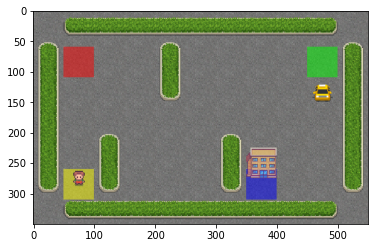

In [12]:
env = gym.make("Taxi-v3").env

env.reset()

# if you run on Google Colab
prev_screen = env.render(mode = 'rgb_array')
plt.imshow(prev_screen)

# if you run on your own machine
# env.render()

**Understand the gym environment**

As described in the source code, there are 500 states and 6 actions in this environment. 

Initially, the passenger and the destination can only spawn at two distinct color tiles.

Each state is encoded with the following information: taxi coordinate, passenger locations, and destination location.

Passenger locations are:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi

Destination locations are:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)

Actions are: 
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

Rewards are:
- -1 per step unless other reward is triggered
- +20 delivering passenger
- -10  executing "pickup" and "drop-off" actions illegally

The environment includes a dictionary P storing the reward for each (state, action) pair. The information stored in P has the following structure: {state: {action: [(probability, nextstate, reward, done)]}}



In [13]:
env.P[10] # shows the rewards in the 10th states

{0: [(1.0, 110, -1, False)],
 1: [(1.0, 10, -1, False)],
 2: [(1.0, 30, -1, False)],
 3: [(1.0, 10, -1, False)],
 4: [(1.0, 10, -10, False)],
 5: [(1.0, 10, -10, False)]}

Note that all probabilities are 1 in this environment.

**Implement Q-learning**

Implement Q-learning by modifying the specified part in the following block. Currently it is only taking a random action.

In [41]:
def Q_learning(env, episodes = 100000, alpha = 0.1, gamma = 0.6, epsilon = 0.1):
    Q_values = np.zeros([env.observation_space.n, env.action_space.n])
    rewards_list = [0] * episodes
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            ########################################################################
            # TO DO: implement Q-learning update
            if np.random.uniform(0, 1) > epsilon:
                action = np.argmax(Q_values[state])
            else:
                action = env.action_space.sample()
            next_state, reward, done, info = env.step(action) # you shouldn't change this line
            Q_values[state, action] = (1 - alpha) * Q_values[state, action] + alpha * (reward + gamma * np.max(Q_values[next_state]))
            ############################# End of your code #########################
            rewards_list[episode] += reward
            state = next_state
    return Q_values, rewards_list

**Train and evaluate**

Run the following block to train and evaluate your implementation.

You are free to write your own code to debug or to test. For example, you can experiment with some more hyperparameter settings. But please do so in a new code block and delete it before submitting. Furthermore, keep in mind that if the number of episodes of training is too small, your agent may not learn enough information and get stuck during testing forever.

100%|██████████| 1000/1000 [00:00<00:00, 2461.87it/s]


Average steps per episode: 13.08
Number of failures: 0


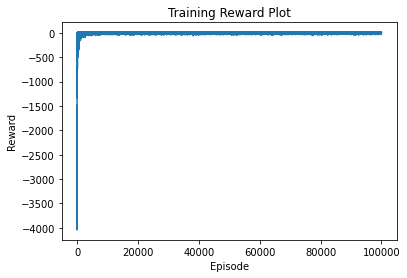

In [42]:
env.reset()
Q_values, rewards_list = Q_learning(env)

episodes = 1000
steps_count, failures_count = 0, 0

for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = np.argmax(Q_values[state])
        state, reward, done, info = env.step(action)
        steps_count += 1
        failures_count += reward == -10

print("Average steps per episode: " + str(np.round(steps_count / episodes, 2))) # should be less than 20
print("Number of failures: " + str(failures_count)) # should be very very low

# the curve should be overall increasing
fig, ax = plt.subplots()
ax.plot(rewards_list)
ax.set_title("Training Reward Plot")
ax.set_xlabel("Episode")
ax.set_ylabel("Reward")
plt.show()